In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    average_precision_score
)
import shap
import random
import os

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [93]:
# %%

# Configurações do Pandas e Matplotlib
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)


# URLs da API do NASA Exoplanet Archive
BASE_URL = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query="
KEPLER_QUERY = "select+*+from+cumulative"
TESS_QUERY = "select+*+from+toi"
K2_QUERY = "select+*+from+k2pandc"
FORMAT = "&format=csv"

# --- Carregar dados do Kepler ---
print("Carregando dados do Kepler...")
kepler_url = f"{BASE_URL}{KEPLER_QUERY}{FORMAT}"
kepler_df = pd.read_csv(kepler_url)
print(f"Kepler carregado. Shape: {kepler_df.shape}")


# --- Carregar dados do TESS ---
print("\nCarregando dados do TESS...")
tess_url = f"{BASE_URL}{TESS_QUERY}{FORMAT}"
tess_df = pd.read_csv(tess_url)
print(f"TESS carregado. Shape: {tess_df.shape}")


# --- Carregar dados do K2 ---
print("\nCarregando dados do K2...")
k2_url = f"{BASE_URL}{K2_QUERY}{FORMAT}"
k2_df = pd.read_csv(k2_url)
print(f"K2 carregado. Shape: {k2_df.shape}")


Carregando dados do Kepler...
Kepler carregado. Shape: (9564, 153)

Carregando dados do TESS...
TESS carregado. Shape: (7703, 91)

Carregando dados do K2...
K2 carregado. Shape: (4004, 361)


/tmp/ipykernel_107007/905539807.py:33: DtypeWarning: Columns (72) have mixed types. Specify dtype option on import or set low_memory=False.
  k2_df = pd.read_csv(k2_url)


In [94]:

# %%
# ==============================================================================
# 2. SELEÇÃO, RENOMEAÇÃO E PADRONIZAÇÃO
# ==============================================================================

# --- Processamento do Kepler ---
kepler_map = {
	'kepoi_name': 'transit_id',
    'koi_disposition': 'disposition',
    'koi_period': 'pl_period',
    'koi_duration': 'pl_transit_duration',
    'koi_depth': 'pl_transit_depth',
    'koi_prad': 'pl_radius',
    'koi_teq': 'pl_eq_temp',
    'koi_insol': 'pl_insolation_flux',
    'koi_steff': 'st_eff_temp',
    'koi_srad': 'st_radius',
    'koi_slogg': 'st_logg',
    'ra': 'ra',
    'dec': 'dec'
}
kepler_final = kepler_df[list(kepler_map.keys())].rename(columns=kepler_map)
kepler_final['source'] = 'Kepler'


true_planets_kepler = ['CONFIRMED', 'CANDIDATE']
kepler_final['isPlanet'] = kepler_final['disposition'].apply(lambda x: 1 if x in true_planets_kepler else 0)


In [ ]:
tess_map = {
	'toi': 'transit_id',
	'tfopwg_disp': 'disposition',
	'pl_orbper': 'pl_period',
	'pl_trandurh': 'pl_transit_duration',
	'pl_trandep': 'pl_transit_depth', # ppm
	'pl_rade': 'pl_radius',
	'pl_eqt': 'pl_eq_temp',
	'pl_insol': 'pl_insolation_flux',
	'st_teff': 'st_eff_temp',
	'st_rad': 'st_radius',
	'st_logg': 'st_logg',
	'ra': 'ra',
	'dec': 'dec'
}
tess_final = tess_df[list(tess_map.keys())].rename(columns=tess_map)
tess_final['source'] = 'TESS'

In [96]:

# --- Processamento do TESS ---


# Criar a variável alvo 'isPlanet'
# PC (Planetary Candidate), CP (Confirmed Planet), KP (Known Planet) -> 1
# FP (False Positive), FA (False Alarm) -> 0
true_planets_tess = ['PC', 'CP', 'KP']
tess_final['isPlanet'] = tess_final['disposition'].apply(lambda x: 1 if x in true_planets_tess else 0)

# --- Processamento do K2 ---
k2_map = {
	'k2_name': 'transit_id',
	'disposition': 'disposition',
	'pl_orbper': 'pl_period',
	'pl_trandur': 'pl_transit_duration',
	'pl_trandep': 'pl_transit_depth', # % -> precisa converter para ppm
	'pl_rade': 'pl_radius',
	'pl_eqt': 'pl_eq_temp',
	'pl_insol': 'pl_insolation_flux',
	'st_teff': 'st_eff_temp',
	'st_rad': 'st_radius',
	'st_logg': 'st_logg',
	'ra': 'ra',
	'dec': 'dec'
}
k2_final = k2_df[list(k2_map.keys())].rename(columns=k2_map)
k2_final['source'] = 'K2'

# Converter profundidade de % para ppm
# 1% = 10,000 ppm
k2_final['pl_transit_depth'] = k2_final['pl_transit_depth'] * 10000

# Criar a variável alvo 'isPlanet'
# CONFIRMED, CANDIDATE -> 1
# FALSE POSITIVE -> 0
true_planets_k2 = ['CONFIRMED', 'CANDIDATE']
k2_final['isPlanet'] = k2_final['disposition'].apply(lambda x: 1 if x in true_planets_k2 else 0)


print("\nProcessamento concluído.")
print(f"Kepler final: {kepler_final.shape}")
print(f"TESS final: {tess_final.shape}")
print(f"K2 final: {k2_final.shape}")


Processamento concluído.
Kepler final: (9564, 15)
TESS final: (7703, 15)
K2 final: (4004, 15)


In [97]:


# %%
# ==============================================================================
# 3. CONCATENAÇÃO E LIMPEZA FINAL
# ==============================================================================
final_df = pd.concat([kepler_final, tess_final, k2_final], ignore_index=True)

# Remover a coluna original de disposição, pois já temos 'isPlanet'
final_df = final_df.drop(columns=['disposition'])

print(f"\nDataset unificado criado. Shape: {final_df.shape}")


final_df


Dataset unificado criado. Shape: (21271, 14)


,transit_id,pl_period,pl_transit_duration,pl_transit_depth,pl_radius,pl_eq_temp,pl_insolation_flux,st_eff_temp,st_radius,st_logg,ra,dec,source,isPlanet
0,K00752.01,9.488036,2.95750,615.8,2.26,793.0,93.59,5455.00,0.927000,4.46700,291.934230,48.141651,Kepler,1
1,K00752.02,54.418383,4.50700,874.8,2.83,443.0,9.11,5455.00,0.927000,4.46700,291.934230,48.141651,Kepler,1
2,K00753.01,19.899140,1.78220,10829.0,14.60,638.0,39.30,5853.00,0.868000,4.54400,297.004820,48.134129,Kepler,1
3,K00754.01,1.736952,2.40641,8079.2,33.46,1395.0,891.96,5805.00,0.791000,4.56400,285.534610,48.285210,Kepler,0
4,K00755.01,2.525592,1.65450,603.3,2.75,1406.0,926.16,6031.00,1.046000,4.43800,288.754880,48.226200,Kepler,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21266,NaN,1.889930,1.65600,367.0,1.29,NaN,NaN,NaN,0.638000,NaN,128.310980,17.261418,K2,1
21267,NaN,1.830767,2.84880,157032.0,NaN,NaN,NaN,6141.42,0.987120,4.51379,137.317315,21.002565,K2,0
21268,NaN,15.246593,3.76080,NaN,78.00,NaN,NaN,NaN,1.910000,NaN,14.744463,7.719319,K2,1
21269,NaN,10.555000,1.30704,1249.0,NaN,NaN,NaN,4067.08,0.722281,4.52683,136.157024,19.714414,K2,1


/tmp/ipykernel_107007/3978502417.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_info_sorted.index, y=missing_info_sorted['Percentual Nulos (%)'], palette='viridis')



--- Análise de Valores Nulos ---
                     Contagem Nulos  Percentual Nulos (%)
pl_insolation_flux             3871             18.198486
pl_eq_temp                     3824             17.977528
st_logg                        2867             13.478445
pl_transit_depth               2268             10.662404
pl_radius                      1700              7.992102
transit_id                     1699              7.987401
st_eff_temp                    1636              7.691223
pl_transit_duration            1221              5.740210
st_radius                      1000              4.701236
pl_period                       151              0.709887


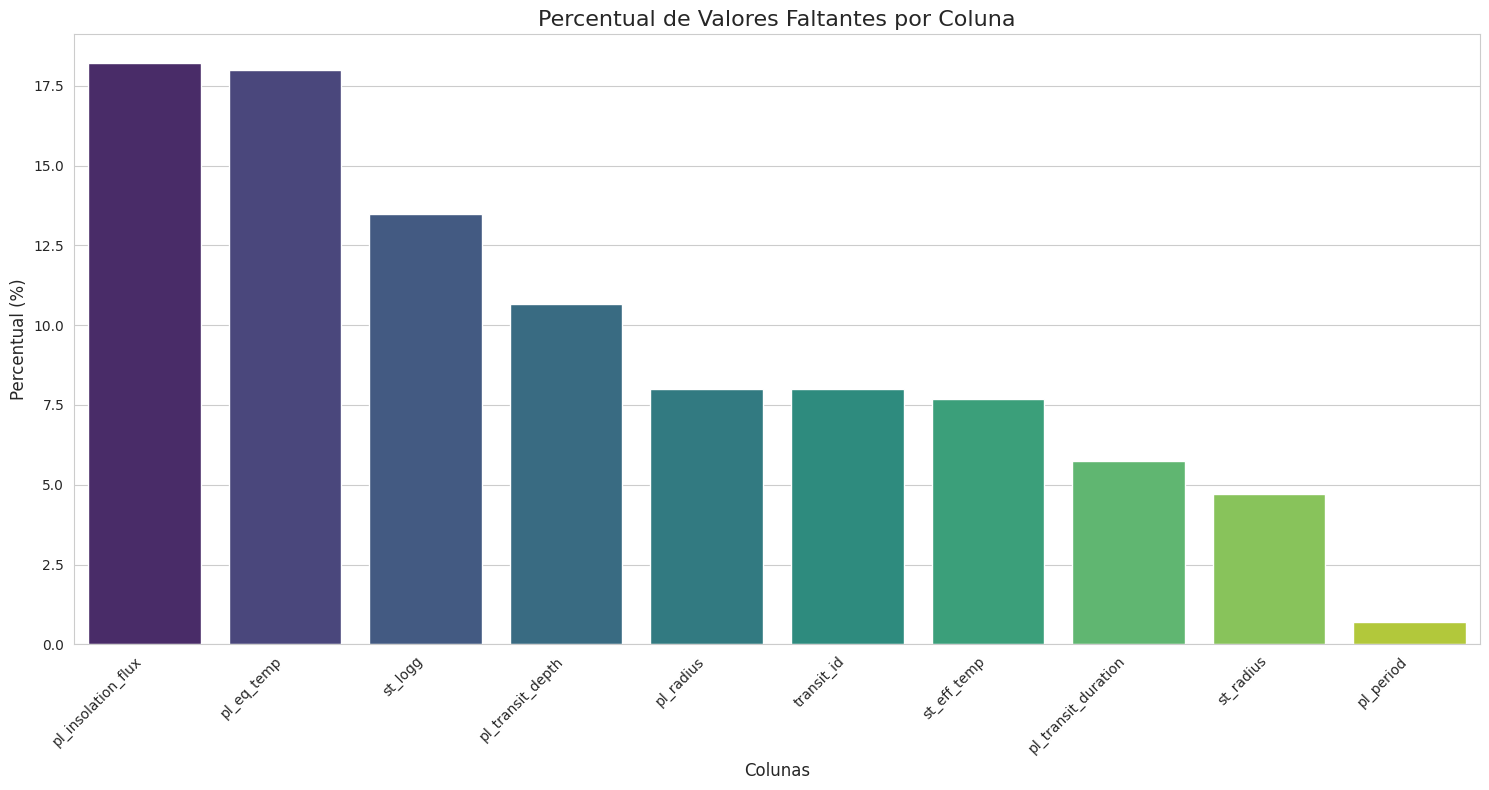


--- Análise de Colunas com Valor Único ---
Nenhuma coluna com apenas um valor único foi encontrada.

--- Resumo Final da Qualidade dos Dados ---
Shape do dataset original unificado: (21271, 14)
Shape do dataset após limpeza de colunas de valor único: (21271, 14)

O dataset está pronto para a próxima etapa: tratamento de valores nulos (imputação).


In [98]:
# ==============================================================================
# 2. ANÁLISE DE QUALIDADE DE DADOS APROFUNDADA
# ==============================================================================

# --- Análise Detalhada de Valores Nulos ---
print("\n" + "="*50)
print("--- Análise de Valores Nulos ---")
print("="*50)
missing_values = final_df.isnull().sum()
missing_percentage = (missing_values / len(final_df)) * 100
missing_info = pd.DataFrame({
	'Contagem Nulos': missing_values,
	'Percentual Nulos (%)': missing_percentage
})
missing_info_sorted = missing_info[missing_info['Contagem Nulos'] > 0].sort_values(
	by='Percentual Nulos (%)', ascending=False
)

if not missing_info_sorted.empty:
	print(missing_info_sorted)

	# Visualização dos valores nulos
	plt.figure(figsize=(15, 8))
	sns.barplot(x=missing_info_sorted.index, y=missing_info_sorted['Percentual Nulos (%)'], palette='viridis')
	plt.xticks(rotation=45, ha='right')
	plt.title('Percentual de Valores Faltantes por Coluna', fontsize=16)
	plt.ylabel('Percentual (%)', fontsize=12)
	plt.xlabel('Colunas', fontsize=12)
	plt.tight_layout()
	plt.show()
else:
	print("Nenhum valor nulo encontrado no dataset.")


# --- Análise de Colunas com Valor Único ---
print("\n" + "="*50)
print("--- Análise de Colunas com Valor Único ---")
print("="*50)
unique_value_counts = final_df.nunique()
single_value_cols = unique_value_counts[unique_value_counts <= 1].index.tolist()

if single_value_cols:
	print(f"As seguintes colunas contêm apenas um valor único e DEVEM ser removidas:")
	for col in single_value_cols:
		# .dropna() para garantir que o valor único não seja NaN
		unique_val = final_df[col].dropna().unique()
		valor = unique_val[0] if len(unique_val) > 0 else "Apenas Nulos"
		print(f"- Coluna: '{col}' | Valor Constante: {valor}")
	
	# Removendo as colunas
	df_cleaned = final_df.drop(columns=single_value_cols)
	print("\nColunas com valor único foram removidas.")
else:
	print("Nenhuma coluna com apenas um valor único foi encontrada.")
	df_cleaned = final_df.copy()

# --- Resumo Final ---
print("\n" + "="*50)
print("--- Resumo Final da Qualidade dos Dados ---")
print("="*50)
print(f"Shape do dataset original unificado: {final_df.shape}")
print(f"Shape do dataset após limpeza de colunas de valor único: {df_cleaned.shape}")
print(f"\nO dataset está pronto para a próxima etapa: tratamento de valores nulos (imputação).")




In [99]:
#shape antes de remover os nulos
print("Shape antes de remover os nulos:", df_cleaned.shape)

#limpa todos os valores nulos
df_cleaned = df_cleaned.dropna()

#shape após remover os nulos
print("Shape após remover os nulos:", df_cleaned.shape)

data_final = df_cleaned.copy()

Shape antes de remover os nulos: (21271, 14)
Shape após remover os nulos: (15960, 14)


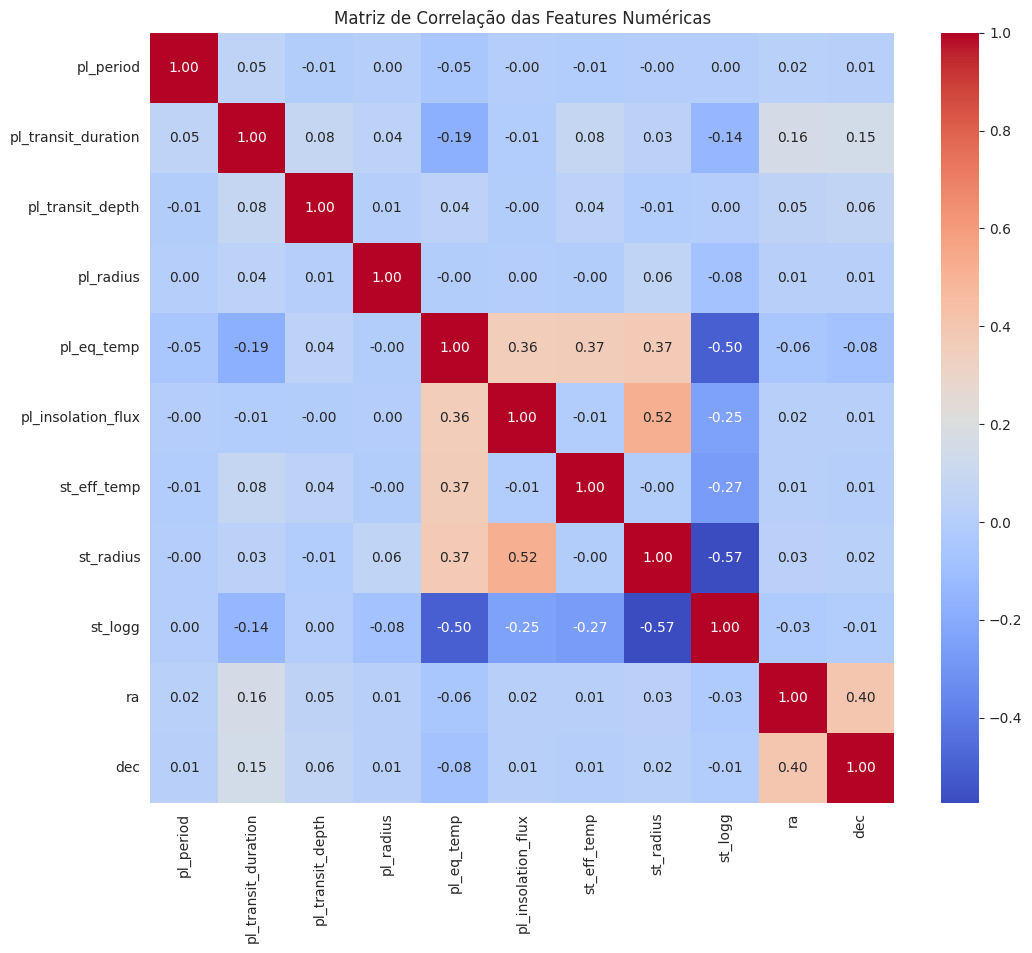

In [100]:


# %%
# ==============================================================================
# 4. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)
# ==============================================================================

# # --- Informações Gerais e Estatísticas Descritivas ---
# print("\n--- Informações Gerais do Dataset ---")
# final_df.info()

# print("\n--- Estatísticas Descritivas ---")
# display(final_df.describe())

# # --- Verificação de Valores Nulos ---
# print("\n--- Contagem de Valores Nulos por Coluna ---")
# print(final_df.isnull().sum().sort_values(ascending=False))

# # --- Distribuição da Variável Alvo e da Origem dos Dados ---
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
# sns.countplot(x='isPlanet', data=final_df)
# plt.title('Distribuição da Variável Alvo (isPlanet)')
# plt.xlabel('0: Falso Positivo | 1: Planeta/Candidato')

# plt.subplot(1, 2, 2)
# sns.countplot(x='source', data=final_df, order=final_df['source'].value_counts().index)
# plt.title('Distribuição da Origem dos Dados')
# plt.tight_layout()
# plt.show()

# # --- Distribuição das Features Numéricas ---
numeric_features = final_df.select_dtypes(include=np.number).columns.drop('isPlanet')
# for col in numeric_features:
#     plt.figure(figsize=(14, 6))
    
#     # Histograma com escala linear
#     plt.subplot(1, 2, 1)
#     sns.histplot(data=final_df, x=col, hue='isPlanet', kde=True, palette='viridis')
#     plt.title(f'Distribuição de {col} (Escala Linear)')
    
#     # Histograma com escala logarítmica (útil para dados com grande amplitude)
#     plt.subplot(1, 2, 2)
#     # Adicionar um pequeno valor para evitar log(0)
#     log_data = np.log1p(final_df[col].dropna())
#     sns.histplot(x=log_data, hue=final_df.loc[final_df[col].notna(), 'isPlanet'], kde=True, palette='plasma')
#     plt.title(f'Distribuição de {col} (Escala Log)')
#     plt.xlabel(f'log({col})')
    
#     plt.tight_layout()
#     plt.show()

# --- Matriz de Correlação ---
plt.figure(figsize=(12, 10))
correlation_matrix = final_df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Features Numéricas')
plt.show()

In [107]:
# ==============================================================================
# 4. PREPARAÇÃO PARA MODELAGEM (VERSÃO ATUALIZADA COM ID)
# ==============================================================================
from sklearn.model_selection import GroupShuffleSplit

# --- Criar um ID de Agrupamento (star_id) ---
data_final['star_id'] = data_final['ra'].astype(str) + '_' + data_final['dec'].astype(str)


# Numero total de linhas
num_rows = data_final.shape[0]
print(f"Número total de linhas no dataset: {num_rows}")

# Numero de estrelas unicas
num_stars = data_final['star_id'].nunique()
print(f"\nNúmero de sistemas estelares únicos (star_id): {num_stars}")

# --- Separar colunas de features, metadados e alvo ---
# O ID do trânsito é um metadado, não uma feature para o modelo aprender!
metadata_cols = ['transit_id', 'star_id', 'source', 'ra', 'dec']
target_col = 'isPlanet'
feature_cols = [col for col in data_final.columns if col not in metadata_cols + [target_col]]

print("Features que serão usadas no modelo:", feature_cols)

# --- Dividir os dados em treino e teste (hold-out) usando GroupShuffleSplit ---
# Esta é a forma mais correta de garantir que não há vazamento de dados
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
train_idx, test_idx = next(gss.split(data_final[feature_cols], data_final[target_col], data_final['star_id']))

train_df = data_final.iloc[train_idx]
test_df = data_final.iloc[test_idx]

print(f"\nDados separados (respeitando os sistemas estelares):")
print(f"  - Conjunto de Treino/Validação: {train_df.shape[0]} amostras")
print(f"  - Conjunto de Teste (Hold-Out): {test_df.shape[0]} amostras")

# --- Exportar o conjunto de teste para um CSV (COM O ID) ---
csv_filename = 'dados_para_predicao.csv'
# Criamos o CSV apenas com o ID e as features necessárias para a predição
test_df[['transit_id'] + feature_cols].to_csv(csv_filename, index=False)
print(f"\nDados de teste com ID salvos em '{csv_filename}'")

# --- Preparar variáveis para o restante do script de treinamento ---
X = train_df[feature_cols]
y = train_df[target_col]
groups = train_df['star_id']

Número total de linhas no dataset: 15960

Número de sistemas estelares únicos (star_id): 14384
Features que serão usadas no modelo: ['pl_period', 'pl_transit_duration', 'pl_transit_depth', 'pl_radius', 'pl_eq_temp', 'pl_insolation_flux', 'st_eff_temp', 'st_radius', 'st_logg']

Dados separados (respeitando os sistemas estelares):
  - Conjunto de Treino/Validação: 13561 amostras
  - Conjunto de Teste (Hold-Out): 2399 amostras

Dados de teste com ID salvos em 'dados_para_predicao.csv'


In [ ]:
# %%
# ==============================================================================
# 5. DEFINIÇÃO E TREINAMENTO DOS MODELOS (DO SCRIPT 2)
# ==============================================================================

# --- Calcular o peso para classes desbalanceadas (para XGBoost) ---
count_neg = y.value_counts().get(0, 0)
count_pos = y.value_counts().get(1, 0)
scale_pos_weight = count_neg / count_pos if count_pos > 0 else 1
print(f"\nScale Pos Weight para XGBoost: {scale_pos_weight:.2f}")


models = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=SEED),
    "Random Forest": RandomForestClassifier(random_state=SEED, class_weight='balanced'),
    "SVM": SVC(random_state=SEED, probability=True, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=SEED, eval_metric='logloss', scale_pos_weight=scale_pos_weight),
    "XGBoost (Tunado)": XGBClassifier(
        random_state=SEED, eval_metric='logloss', scale_pos_weight=scale_pos_weight,
        n_estimators=600, learning_rate=0.04, max_depth=6, subsample=0.8, colsample_bytree=0.8
    ),
    "LightGBM": LGBMClassifier(random_state=SEED, class_weight='balanced'),
    "LightGBM (Tunado)": LGBMClassifier(
        random_state=SEED, class_weight='balanced', n_estimators=500, learning_rate=0.05
    ),
# 	Otimização concluída!
# Melhor valor (AUC ROC médio): 0.8977
# Melhores hiperparâmetros encontrados:
# {'n_estimators': 1600, 'learning_rate': 0.002865832106246123, 'lambda_l1': 1.1212412169964432e-08, 'lambda_l2': 0.2183498289760726, 'num_leaves': 359, 'max_depth': 10, 'feature_fraction': 0.8856351733429728, 'bagging_fraction': 0.5370223258670452, 'bagging_freq': 3, 'min_child_samples': 16}

	"LightGBM (Optuna)": LGBMClassifier(
		random_state=SEED, class_weight='balanced', n_estimators=1600, learning_rate=0.002865832106246123,
		lambda_l1=1.1212412169964432e-08, lambda_l2=0.2183498289760726, num_leaves=359, max_depth=10,
		feature_fraction=0.8856351733429728, bagging_fraction=0.5370223258670452, bagging_freq=3, min_child_samples=16
	)
}


Scale Pos Weight para XGBoost: 0.59


In [110]:
# ==============================================================================
# 6. VALIDAÇÃO CRUZADA E AVALIAÇÃO (COM MÉTRICAS ADICIONAIS)
# ==============================================================================
results = []
n_splits = 5
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

for name, model in models.items():
	print(f"\nValidando o modelo: {name}...")
	# Listas para armazenar as métricas de cada fold
	fold_roc_aucs, fold_prc_aucs, fold_accuracies = [], [], []
	fold_f1_planet, fold_f1_fp = [], []
	fold_prec_planet, fold_rec_planet = [], [] # <-- NOVA LINHA: Listas para as novas métricas
	fold_prec_non_planet, fold_rec_non_planet = [], [] # <-- NOVA LINHA: Listas para as novas métricas

	for fold, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups)):
		print(f"  - Processando Fold {fold+1}/{n_splits}")
		X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
		y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

		# Padronização dos dados DENTRO do loop
		scaler = StandardScaler()
		X_train_scaled = scaler.fit_transform(X_train)
		X_test_scaled = scaler.transform(X_test)

		model.fit(X_train_scaled, y_train)
		y_pred = model.predict(X_test_scaled)
		y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

		# Calcular métricas
		fold_roc_aucs.append(roc_auc_score(y_test, y_pred_proba))
		fold_prc_aucs.append(average_precision_score(y_test, y_pred_proba))
		fold_accuracies.append(accuracy_score(y_test, y_pred))

		report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
		
		# Extrair e armazenar as métricas para a classe '1' (Planeta)
		fold_f1_planet.append(report.get('1', {}).get('f1-score', 0))
		fold_prec_planet.append(report.get('1', {}).get('precision', 0))
		fold_rec_planet.append(report.get('1', {}).get('recall', 0))
		fold_prec_non_planet.append(report.get('0', {}).get('precision', 0))
		fold_rec_non_planet.append(report.get('0', {}).get('recall', 0))
		
		# Extrair F1 para a classe '0' (Falso Positivo)
		fold_f1_fp.append(report.get('0', {}).get('f1-score', 0))

	# Calcular a média das métricas entre os folds e adicionar ao resultado
	results.append({
		"Modelo": name,
		"AUC ROC Média": np.mean(fold_roc_aucs),
		"AUC PRC Média": np.mean(fold_prc_aucs),
		"Acurácia Média": np.mean(fold_accuracies),
		"Precisão (Planeta) Média": np.mean(fold_prec_planet),
		"Recall (Planeta) Média": np.mean(fold_rec_planet),
		"Precisão (Non Planet) Média": np.mean(fold_prec_non_planet),
		"Recall (Non Planet) Média": np.mean(fold_rec_non_planet),
		"F1 (Planeta) Média": np.mean(fold_f1_planet),
		"F1 (Non Planet) Média": np.mean(fold_f1_fp)
	})

print("\nTodos os modelos foram avaliados.")

# --- Exibir Resultados ---
results_df = pd.DataFrame(results).sort_values(by="AUC ROC Média", ascending=False)

# Adicionar formatação para as novas colunas
display(results_df.style.format({
	'AUC ROC Média': '{:.4f}', 'AUC ROC Std': '{:.4f}', 'AUC PRC Média': '{:.4f}',
	'Acurácia Média': '{:.4f}', 'F1 (Planeta) Média': '{:.4f}', 
	'Precisão (Planeta) Média': '{:.4f}', 'Recall (Planeta) Média': '{:.4f}', # <-- NOVA LINHA
	'F1 (Non Planet) Média': '{:.4f}'
}).background_gradient(cmap='viridis', subset=['AUC ROC Média', 'AUC PRC Média', 'F1 (Planeta) Média']))


Validando o modelo: Gradient Boosting...
  - Processando Fold 1/5
  - Processando Fold 2/5
  - Processando Fold 3/5
  - Processando Fold 4/5
  - Processando Fold 5/5

Validando o modelo: Random Forest...
  - Processando Fold 1/5
  - Processando Fold 2/5
  - Processando Fold 3/5
  - Processando Fold 4/5
  - Processando Fold 5/5

Validando o modelo: SVM...
  - Processando Fold 1/5
  - Processando Fold 2/5
  - Processando Fold 3/5
  - Processando Fold 4/5
  - Processando Fold 5/5

Validando o modelo: XGBoost...
  - Processando Fold 1/5
  - Processando Fold 2/5
  - Processando Fold 3/5
  - Processando Fold 4/5
  - Processando Fold 5/5

Validando o modelo: XGBoost (Tunado)...
  - Processando Fold 1/5
  - Processando Fold 2/5
  - Processando Fold 3/5
  - Processando Fold 4/5
  - Processando Fold 5/5

Validando o modelo: LightGBM...
  - Processando Fold 1/5
  - Processando Fold 2/5
  - Processando Fold 3/5


/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/v

  - Processando Fold 4/5
  - Processando Fold 5/5


/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Validando o modelo: LightGBM (Tunado)...
  - Processando Fold 1/5


/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 2/5


/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 3/5


/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 4/5


/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 5/5


/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Validando o modelo: LightGBM (Optuna)...
  - Processando Fold 1/5


/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 2/5


/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 3/5


/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 4/5


/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 5/5


/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/guilherme.fracalossi/miniconda3/envs/nasa/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Todos os modelos foram avaliados.


,Modelo,AUC ROC Média,AUC PRC Média,Acurácia Média,Precisão (Planeta) Média,Recall (Planeta) Média,Precisão (Non Planet) Média,Recall (Non Planet) Média,F1 (Planeta) Média,F1 (Non Planet) Média
7,LightGBM (Optuna),0.8977,0.9243,0.8323,0.8636,0.8709,0.778264,0.766530,0.8672,0.7722
5,LightGBM,0.8933,0.9185,0.8254,0.8604,0.8622,0.765682,0.762460,0.8613,0.7640
4,XGBoost (Tunado),0.8932,0.9203,0.8285,0.8591,0.8701,0.775184,0.757756,0.8645,0.7662
1,Random Forest,0.8912,0.9190,0.8247,0.8327,0.9025,0.807707,0.692251,0.8662,0.7454
6,LightGBM (Tunado),0.8910,0.9173,0.8263,0.8563,0.8698,0.773172,0.752151,0.8630,0.7624
3,XGBoost,0.8864,0.9132,0.8247,0.8577,0.8648,0.767688,0.756350,0.8612,0.7618
0,Gradient Boosting,0.8822,0.9091,0.8167,0.8141,0.9183,0.823140,0.643970,0.8630,0.7225
2,SVM,0.8300,0.8663,0.7815,0.8021,0.8662,0.737689,0.637488,0.8329,0.6839


In [111]:
best_model_name = results_df.iloc[0]['Modelo']
best_model = models[best_model_name]

print(f"\nO melhor modelo foi: '{best_model_name}'")

final_scaler = StandardScaler()
X_scaled_final = final_scaler.fit_transform(X)

print("Treinando o modelo final com todos os dados...")
best_model.fit(X_scaled_final, y)
print("Modelo final treinado com sucesso!")

print("\n--- Análise de Importância de Features (Nativa do Modelo) ---")


O melhor modelo foi: 'LightGBM (Optuna)'
Treinando o modelo final com todos os dados...
Modelo final treinado com sucesso!

--- Análise de Importância de Features (Nativa do Modelo) ---


In [112]:
# %%
# ==============================================================================
# 8. SALVAR O MODELO E O SCALER PARA PRODUÇÃO
# ==============================================================================
import joblib

# Definir os nomes dos arquivos
model_filename = 'modelo_exoplanetas.joblib'
scaler_filename = 'scaler_exoplanetas.joblib'

# Salvar o modelo treinado
joblib.dump(best_model, model_filename)
print(f"Modelo salvo com sucesso em: '{model_filename}'")

# Salvar o objeto scaler treinado
joblib.dump(final_scaler, scaler_filename)
print(f"Scaler salvo com sucesso em: '{scaler_filename}'")

Modelo salvo com sucesso em: 'modelo_exoplanetas.joblib'
Scaler salvo com sucesso em: 'scaler_exoplanetas.joblib'
